# Email Spam-Ham Detection

#### In this project, we build a spam detector using 5 Machine Learning models and evaluate them with test data using different performance metrics used. The dataset we used was from real emails from Enron  containing both spam and ham emails in different proportions. As per our analysis, Naive Bayes model and SVM have relatively better accuracy for spam detection among all the models

### Dataset Used :- The Enron Email 

Dataset Description:- This is one of the biggest email data sources in the world. Almost half a million files spread over 2.5 GB. Normally, emails are very sensitive, and rarely released to the public, but because of the shocking nature of Enron’s collapse, everything was released to the public.



In [1]:
#Import all the required libraries
import urllib.request
import os  # The OS module in python provides functions for interacting with the operating system. 
import tarfile # The tarfile module makes it possible to read and write tar archives.
import pickle # Python pickle module is used for serializing and de-serializing python object structures.

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#Machine Learning algorithms to implement
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#import metrics libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#For Visualisation purpose
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Download Dataset

Download a set of spam and ham actual emails. Each email is a separate plain text file. Unzip the compressed tar files, read the text and load it into a Pandas Dataframe. Convert the dataframe to a Pickle object.

In [2]:
# Get the user's Downloads folder path
home = os.path.expanduser('~')
downloads = os.path.join(home, 'Downloads')
#Give the URL name.
url = "http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/"
enron_dir = os.path.join(downloads, 'Enron emails')
# These are our tar files which we want to download for our project.
enron_files = ['enron1.tar.gz', 'enron2.tar.gz', 'enron3.tar.gz',
               'enron4.tar.gz', 'enron5.tar.gz', 'enron6.tar.gz']

In [3]:
#It wil download the dataset in our directories if and only if the directory is not created and
#datasets are not present in the directories.
def download(): 
    # Create the directories.
    if not os.path.exists(enron_dir):
        os.makedirs(enron_dir)
    # Download the files that not exist.
    for file in enron_files:
        path = os.path.join(enron_dir, file)
        if not os.path.exists(path):
            urllib.request.urlretrieve(url + file, path)


In [4]:
#xtract the zipped emails and load them into a pandas df.
def extract_emails(fname):  
    rows = []
    tfile = tarfile.open(fname, 'r:gz') # fname (str): the files with tar.gz extension
    for member in tfile.getmembers():
        if 'ham' in member.name:
            f = tfile.extractfile(member)
            if f is not None:
                row = f.read()
                rows.append({'message': row, 'class': 'ham'})
        if 'spam' in member.name:
            f = tfile.extractfile(member)
            if f is not None:
                row = f.read()
                rows.append({'message': row, 'class': 'spam'})
    tfile.close()
    return pd.DataFrame(rows) # pandas df: a pandas dataframe of emails

In [5]:
#Populate the df with all the emails and save it to a pickle object.
#The process to converts any kind of python objects (list, dict, etc.) into byte streams (0s and 1s) is called pickling or serialization
#Why Pickle?: In real world sceanario, the use pickling and unpickling are widespread as they allow us to 
#             easily transfer data from one server/system to another and then store it in a file or database.
def populate_df_and_pickle():
    if not os.path.exists(downloads + "/emails.pickle"):
        emails_df = pd.DataFrame({'message': [], 'class': []})
        for file in enron_files:
            unzipped_file = extract_emails(os.path.join(enron_dir, file))
            emails_df = emails_df.append(unzipped_file)
        emails_df.to_pickle(downloads + "/emails.pickle")

if __name__ == '__main__':
    download()
    populate_df_and_pickle()
    print("Download, unzip, and save to pickle done!")

Download, unzip, and save to pickle done!


In [6]:
# Open the dataset.
with open(downloads + '/emails.pickle', 'rb') as f:
    emails_df = pickle.load(f) 

# Translate bytes objects into strings.
emails_df['message'] = emails_df['message'].apply(lambda x: x.decode('latin-1'))

# Reset pandas df index.
emails_df = emails_df.reset_index(drop=True)


In [7]:
#How the dataframe looks like now?
emails_df.head()

,message,class
0,Subject: christmas tree farm pictures\r\n,ham
1,"Subject: vastar resources , inc .\r\ngary , pr...",ham
2,Subject: calpine daily gas nomination\r\n- cal...,ham
3,Subject: re : issue\r\nfyi - see note below - ...,ham
4,Subject: meter 7268 nov allocation\r\nfyi .\r\...,ham


In [8]:
# Map 'spam' to 1 and 'ham' to 0.
emails_df['class'] = emails_df['class'].map({'spam':1, 'ham':0})

print(emails_df.index)
emails_df.shape

RangeIndex(start=0, stop=33716, step=1)


(33716, 2)

In [9]:
#after mapping:-
print(emails_df.head())

#A more detailed view of a single email
emails_df.iloc[18].values

                                             message  class
0          Subject: christmas tree farm pictures\r\n      0
1  Subject: vastar resources , inc .\r\ngary , pr...      0
2  Subject: calpine daily gas nomination\r\n- cal...      0
3  Subject: re : issue\r\nfyi - see note below - ...      0
4  Subject: meter 7268 nov allocation\r\nfyi .\r\...      0


array(['Subject: hpl fuel gas buy - back for december 1999\r\nfyi :\r\n- - - - - - - - - - - - - - - - - - - - - - forwarded by gregg lenart / hou / ect on 12 / 16 / 99 02 : 02 pm\r\n- - - - - - - - - - - - - - - - - - - - - - - - - - -\r\nenron north america corp .\r\nfrom : sally shuler @ enron 12 / 16 / 99 01 : 55 pm\r\nto : gregg lenart / hou / ect @ ect\r\ncc :\r\nsubject : hpl fuel gas buy - back for december 1999\r\n- - - - - - - - - - - - - - - - - - - - - - forwarded by sally shuler / gpgfin / enron on 12 / 16 / 99\r\n02 : 02 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -\r\nmichael mitcham\r\n12 / 16 / 99 01 : 45 pm\r\nto : james prentice / gpgfin / enron @ enron , kerry roper / gpgfin / enron @ enron , sally\r\nshuler / gpgfin / enron @ enron , mark diedrich / gpgfin / enron @ enron , paul\r\nfox / ecf / enron @ enron\r\ncc :\r\nsubject : hpl fuel gas buy - back for december 1999\r\negp fuels fuels co . has sold back 7 , 000 mmbtu / day starting 12 / 17 through\r\n

## Clean the Dataset

we will import re in this module to check if a perticular string matches a given regular expression.The ‘sub’ in the function stands for SubString, a certain regular expression pattern is searched in the given string(3rd parameter), and upon finding the substring pattern is replaced by repl(2nd parameter), count checks and maintains the number of times this occurs. 

In [10]:
from string import punctuation
import re # Regular expression operation
""" 
     Args:
        email (unicode): the email
    Returns:
        email (unicode): only the text of the email
        
    """

#Remove all punctuation, urls, numbers, and newlines.
#Convert to lower case.

def clean_email(email): 
    
    email = re.sub(r'http\S+', ' ', email)
    email = re.sub("\d+", " ", email)
    email = email.replace('\n', ' ')
    email = email.replace('\t', ' ')
    email = email.translate(str.maketrans("", "", punctuation))
    email = email.lower()
    return email # It returns only the text of the email

emails_df['message'] = emails_df['message'].apply(clean_email)

#After cleaning how the email looks like
emails_df.iloc[18].values

array(['subject hpl fuel gas buy  back for december  \r fyi \r                       forwarded by gregg lenart  hou  ect on              pm\r                           \r enron north america corp \r from  sally shuler  enron              pm\r to  gregg lenart  hou  ect  ect\r cc \r subject  hpl fuel gas buy  back for december  \r                       forwarded by sally shuler  gpgfin  enron on        \r      pm                           \r michael mitcham\r              pm\r to  james prentice  gpgfin  enron  enron  kerry roper  gpgfin  enron  enron  sally\r shuler  gpgfin  enron  enron  mark diedrich  gpgfin  enron  enron  paul\r fox  ecf  enron  enron\r cc \r subject  hpl fuel gas buy  back for december  \r egp fuels fuels co  has sold back      mmbtu  day starting      through\r      to hpl at       mmbtu \r if anyone has any questions  please let me know \r thanks',
       0], dtype=object)

## Preprocess the Data

Split the text string into individual words and stem each word. 
Remove english stop words. (Stopwords are the English words which does not add much meaning to a sentence)

### Split and Stem
Split the text by white spaces and link the different forms of the same word to each other, using stemming. For example “responsiveness” and “response” have the same stem/root - “response”.

### Remove Stop Words
Some words such as “the” or “is” appear in all emails and don’t have much content to them. These words are not going to help the algorithm distinguish spam from ham. Such words are called stopwords and they can be disregarded during classification.

In [11]:
#Natural language tool kit
from nltk.stem.snowball import SnowballStemmer

""" Split the text string into individual words, stem each word,
    and append the stemmed word to words. Make sure there's a single
    space between each stemmed word.
    Args:
        email (unicode): the email
    Returns:
        words (unicode): the text of the email
        
    """
def preproces_text(email):  
    words = ""
    # Create the stemmer.
    stemmer = SnowballStemmer("english")
    # Split text into words.
    email = email.split()
    for word in email:
        words = words + stemmer.stem(word) + " "
    
    return words

emails_df['message'] = emails_df['message'].apply(preproces_text)

emails_df.iloc[18].values

array(['subject hpl fuel gas buy back for decemb fyi forward by gregg lenart hou ect on pm enron north america corp from salli shuler enron pm to gregg lenart hou ect ect cc subject hpl fuel gas buy back for decemb forward by salli shuler gpgfin enron on pm michael mitcham pm to jame prentic gpgfin enron enron kerri roper gpgfin enron enron salli shuler gpgfin enron enron mark diedrich gpgfin enron enron paul fox ecf enron enron cc subject hpl fuel gas buy back for decemb egp fuel fuel co has sold back mmbtu day start through to hpl at mmbtu if anyon has ani question pleas let me know thank ',
       0], dtype=object)

## Vectorize Words and Split Data to Train/Test Sets
Transform the words into a tf-idf matrix using the sklearn TfIdf transformation. Then, create train/test sets with the train_test_split function, using stratify parameter. The dataset is highly unbalanced and the stratify parameter will make a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify. For example, if variable y is 0 and 1 and there are 30% of 0’s and 70% of 1’s, stratify=y will make sure that the random split has 30% of 0’s and 75% of 1’s.

In [12]:
# Define the independent variables as Xs.
Xs = emails_df['message'].values

# Define the target (dependent) variable as Ys.
Ys = emails_df['class'].values

# Vectorize words - Turn the text numerical feature vectors,
# Equivalent to CountVectorizer followed by TfidfTransformer.
# using the strategy of tokenization, counting and normalization.
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                       stop_words='english')
Xs = vectorizer.fit_transform(Xs)

# Create a train/test split using 20% test size.
X_train, X_test, y_train, y_test = train_test_split(Xs,
                                                    Ys,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=0,
                                                    stratify=Ys)

feature_names = vectorizer.get_feature_names()
print("Number of different words: {0}".format(len(feature_names)))
print("Word example: {0}".format(feature_names[5369]))

# Check the split printing the shape of each set.
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Number of different words: 119405
Word example: arcadian
(26972, 119405) (26972,)
(6744, 119405) (6744,)


In [13]:
# Check how our dataset looks like now
emails_df

,message,class
0,subject christma tree farm pictur,0
1,subject vastar resourc inc gari product from t...,0
2,subject calpin daili gas nomin calpin daili ga...,0
3,subject re issu fyi see note below alreadi don...,0
4,subject meter nov alloc fyi forward by lauri a...,0
...,...,...
33711,subject iso q good news c edaliss val edumm vl...,1
33712,subject all prescript medicin are on special t...,1
33713,subject the next generat onlin pharmaci are yo...,1
33714,subject bloow in time the time learn how to la...,1


## Train a Classifier
Trained five models using the training data:
    a.    Naive Bayes
    b.    Decision Tree
    c.    SVM
    d.    Random Forest
    e.    Logistic Regression
    
Using the trained models, predicted the email label for test dataset. Calculated four metrics to gauge performance of the models:
    a.    Accuracy
    b.    Precision
    c.    Recall
    d.    F-score

Below are the metrics explanation:-

1. Precision

Precision refers to the closeness of two or more measurements to each other. In Machine Learning, precision is the fraction of relevant instances among the retrieved instances.

   Precision = TP / (TP + FP) (Where TP = True Positive, TN = True Negative, FP = False Positive, FN = False Negative).
   

2. Accuracy

Accuracy refers to the closeness of a measured value to a standard or known value. 

   Accuracy = (TP+TN) / ALL
   

3. Recall

Recall is how many of the true positives were recalled (found), i.e. how many of the correct hits were also found. 

   Recall = TP / (TP + FN)
   

4. F-Score

F-scores are a statistical method for determining accuracy accounting for both precision and recall. It is essentially the harmonic mean of precision and recall.



In [14]:
#function which takes in y test value and y predicted value and prints the associated model performance metrics
def model_assessment(y_test,predicted_class):
    print('confusion matrix')
    print(confusion_matrix(y_test,predicted_class))
    print('accuracy')
    print(accuracy_score(y_test,predicted_class))
    print('precision')
    print(precision_score(y_test,predicted_class))
    print('recall')
    print(recall_score(y_test,predicted_class))
    print('f-Score')
    print(f1_score(y_test,predicted_class))
    fig, ax = plt.subplots(figsize=(3.5,2.5))
    sns.heatmap(confusion_matrix(y_test, predicted_class), 
                annot=True, linewidths=.5, ax=ax, fmt="d").set(xlabel='Predicted Value', ylabel='Expected Value')
    plt.title('Confusion Matrix')

### Naive Bayes Model

Naive Bayes is the easiest classification algorithm (fast to build, regularly used for spam detection). It is a popular (baseline) method for text categorization, the problem of judging documents as belonging to one category or the other (such as spam or legitimate, sports or politics, etc.) with word frequencies as the features.

NB is very simple, easy to implement and fast because essentially you’re just doing a bunch of counts.
If the NB conditional independence assumption holds, then it will converge quicker than discriminative models like logistic regression.
NB needs works well even with less sample data.
NB is highly scalable. It scales linearly with the number of predictors and data points.
NB can be used for both binary and multi-class classification problems and handles continuous and discrete data.
NB is not sensitive to irrelevant features.

confusion matrix
[[3260   49]
 [  54 3381]]
accuracy
0.9847271648873073
precision
0.9857142857142858
recall
0.9842794759825327
f-Score
0.9849963583394027


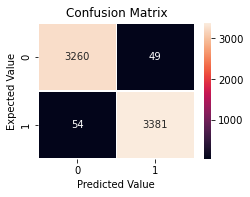

In [15]:
# Create classifier.
modelNB = MultinomialNB()

# Fit the classifier on the training features and labels.
modelNB.fit(X_train, y_train)

# Make prediction - Store predictions in a list named pred.
predicted_class_NB = modelNB.predict(X_test)

#assess NB
model_assessment(y_test,predicted_class_NB)

### Decision Tree Model

Decision trees are used for classification and regression. In decision analysis, a decision tree can be used to visually and explicitly represent decisions and decision making. The decision of making strategic splits heavily affects a tree’s accuracy. The decision criteria is different for classification and regression trees. Information theory is a measure to define this degree of disorganization in a system known as Entropy. If the sample is completely homogeneous, then the entropy is zero and if the sample is an equally divided (50% – 50%), it has entropy of one. It chooses the split which has lowest entropy compared to parent node and other splits. The lesser the entropy, the better it is.

Decision trees implicitly perform variable screening or feature selection. When we fit a decision tree to a training dataset, the top few nodes on which the tree is split are essentially the most important variables within the dataset and feature selection is completed automatically

Decision trees are easy to understand, easy to represent visually and easy to communicate.
Nonlinear relationships between parameters do not affect tree performance. Also trees can explain the non-linearity in an intuitive manner.

confusion matrix
[[3175  134]
 [ 128 3307]]
accuracy
0.9611506524317912
precision
0.9610578320255739
recall
0.9627365356622999
f-Score
0.9618964514252472


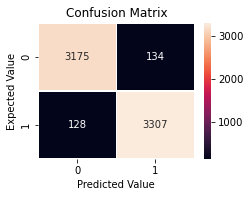

In [16]:
# Create classifier.
model_tree = DecisionTreeClassifier()

# Fit the classifier on the training features and labels.
model_tree.fit(X_train, y_train)

# Make prediction - Store predictions in a list named pred.
predicted_class_tree = model_tree.predict(X_test)

#assess Decision Tree
model_assessment(y_test,predicted_class_tree)


### Support Vector Machine

SVM is a supervised machine learning algorithm which can be used for both classification or regression challenges. However, it is mostly used in classification problems. In this algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyperplane that differentiate the two classes very well. 

Support Vectors are simply the coordinates of individual observation. Support Vector Machine is a frontier which best segregates the two classes (hyper-plane/ line). If the data requires non-linear classification, SVM can employe Kernels, which are functions which takes low dimensional input space and transform it to a higher dimensional space i.e. they convert non separable problem to separable problem.

confusion matrix
[[3246   63]
 [   5 3430]]
accuracy
0.9899169632265717
precision
0.9819639278557114
recall
0.9985443959243085
f-Score
0.9901847575057736


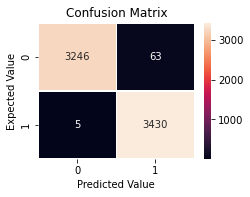

In [17]:
# Create classifier.
model_svm = SVC()

# Fit the classifier on the training features and labels.
model_svm.fit(X_train, y_train)

# Make prediction - Store predictions in a list named pred.
predicted_class_svm = model_svm.predict(X_test)

#assess Support Vector Machine
model_assessment(y_test,predicted_class_svm)


### Random Forest

Random forest is like bootstrapping algorithm with Decision tree (CART) model. Random forest tries to build multiple CART model with different sample and different initial variables. For instance, it will take a random sample of 100 observation and 5 randomly chosen initial variables to build a CART model. It will repeat the process (say) 10 times and then make a final prediction on each observation. Final prediction is a function of each prediction. This final prediction can simply be the mean of each prediction. Random forest gives much more accurate predictions when compared to simple CART/CHAID or regression models in many scenarios. These cases generally have high number of predictive variables and huge sample size. This is because it captures the variance of several input variables at the same time and enables high number of observations to participate in the prediction. 

confusion matrix
[[3246   63]
 [  35 3400]]
accuracy
0.9854685646500593
precision
0.9818076812012706
recall
0.9898107714701602
f-Score
0.9857929834734706


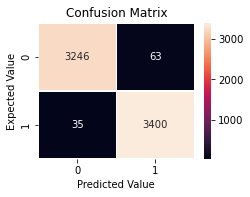

In [18]:
# Create classifier.
model_rf=RandomForestClassifier(n_estimators=20,criterion='entropy')

# Fit the classifier on the training features and labels.
model_rf.fit(X_train, y_train)

# Make prediction - Store predictions in a list named pred.
predicted_class_rf = model_rf.predict(X_test)

#assess Random Forest
model_assessment(y_test,predicted_class_rf)



### Logistic Regression

Logistic regression is a classification algorithm used to find the probability of event success and event failure. It is used when the dependent variable is binary(0/1, True/False, Yes/No) in nature. It supports categorizing data into discrete classes by studying the relationship from a given set of labelled data. It learns a linear relationship from the given dataset and then introduces a non-linearity in the form of the Sigmoid function.

Logistic regression is easier to implement, interpret, and very efficient to train. It makes no assumptions about distributions of classes in feature space.


confusion matrix
[[3209  100]
 [   8 3427]]
accuracy
0.9839857651245552
precision
0.9716472923164162
recall
0.9976710334788937
f-Score
0.9844872163171503


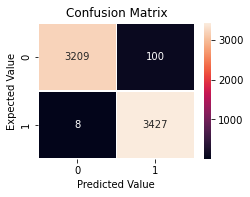

In [19]:
# Create classifier.
model_logr=LogisticRegression(random_state=0)

# Fit the classifier on the training features and labels.
model_logr.fit(X_train, y_train)

# Make prediction - Store predictions in a list named pred.
predicted_class_logr = model_logr.predict(X_test)

#assess Logistic Regression
model_assessment(y_test,predicted_class_logr)

     values Features
0 -7.101930    money
1 -7.081061    price
2 -7.077249    onlin
3 -7.076961    offer
4 -7.064398      www
5 -7.046302  softwar
6 -6.975681    email
7 -6.941401    click
8 -6.658366      com
9 -6.590683     http


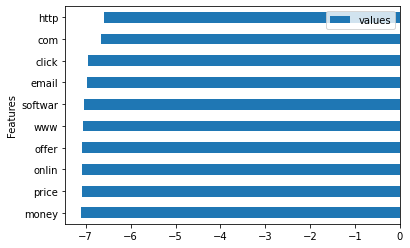

In [20]:
## Identify the Most Powerful Features
## Print the 10 most important features.

def get_most_important_features(vectorizer, classifier,n=10):
    feature_names = vectorizer.get_feature_names()
    df = pd.DataFrame(sorted(zip(classifier.coef_[0],feature_names))[-n:],columns = ['values', 'Features'])
    print(df) 
    ax = df.plot.barh(x='Features', y='values')
    
get_most_important_features(vectorizer, modelNB ,10)

